In [1]:
import numpy as np
from numpy.random import randn
import pandas as pd

# Import stats library from numpy
from scipy import stats

# These are the plotting modules and libraries we'll use:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Command so that plots appear in the iPython Notebook
%matplotlib inline

# Change Theme of plots for better visualization
from jupyterthemes import jtplot

jtplot.style(context='talk', fscale=1, spines=True, gridlines='--')

In [2]:
# Use to grab data from the web(HTTP capabilities)
import requests

# We'll also use StringIO to work with the csv file, the DataFrame will require a .read() method
import io
from io import StringIO

## Setting up the DataFrame

In [3]:
url = "http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv"

# Use requests to get the information in text form
source = requests.get(url).text

poll_data = StringIO(source)

In [4]:
poll_df = pd.read_csv(poll_data)

poll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pollster                586 non-null    object 
 1   Start Date              586 non-null    object 
 2   End Date                586 non-null    object 
 3   Entry Date/Time (ET)    586 non-null    object 
 4   Number of Observations  564 non-null    float64
 5   Population              586 non-null    object 
 6   Mode                    586 non-null    object 
 7   Obama                   586 non-null    float64
 8   Romney                  586 non-null    float64
 9   Undecided               423 non-null    float64
 10  Other                   202 non-null    float64
 11  Pollster URL            586 non-null    object 
 12  Source URL              584 non-null    object 
 13  Partisan                586 non-null    object 
 14  Affiliation             586 non-null    ob

We have 17 columns and 586 entries. 'Other' is missing 384 data points, 'Question Text' is empty, 'Undecided' is missing 163 data points. Remove 'Question Iteration' and 'Question Text'.

All Source URLs are different and all Pollster URLs come from huffingtonpost so it is best to drop these two as well to save computational cost.

In [5]:
poll_df = poll_df.drop(['Question Text','Question Iteration','Pollster URL','Source URL'], axis=1)

In [6]:
poll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pollster                586 non-null    object 
 1   Start Date              586 non-null    object 
 2   End Date                586 non-null    object 
 3   Entry Date/Time (ET)    586 non-null    object 
 4   Number of Observations  564 non-null    float64
 5   Population              586 non-null    object 
 6   Mode                    586 non-null    object 
 7   Obama                   586 non-null    float64
 8   Romney                  586 non-null    float64
 9   Undecided               423 non-null    float64
 10  Other                   202 non-null    float64
 11  Partisan                586 non-null    object 
 12  Affiliation             586 non-null    object 
dtypes: float64(5), object(8)
memory usage: 59.6+ KB


### From looking at the data, there a few questions that I would like to answer.

1.) Who was being polled and what was their party affiliation?

2.) Did the poll results favour Romney or Obama?

3.) How do undecided voters affect the poll?

4.) Can we account for the undecided voters?

5.) How did voter sentiment change over time?

6.) Can we see an effect in the polls from the debates?



Begin by looking at the Affiliation of the voters:

Text(0.5, 1.0, 'Histogram of the Affiliation of voters')

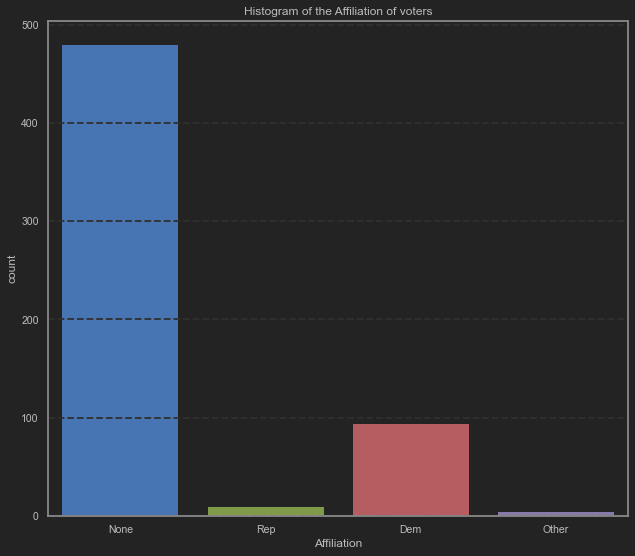

In [7]:
sns.countplot('Affiliation', data = poll_df)

plt.title("Histogram of the Affiliation of voters")

Looks like we are overall relatively neutral, but still leaning towards Democratic Affiliation, it will be good to keep this in mind. Let's see if sorting by the Population hue gives us any further insight into the data.

Text(0.5, 1.0, 'Histogram of the Affiliation of voters')

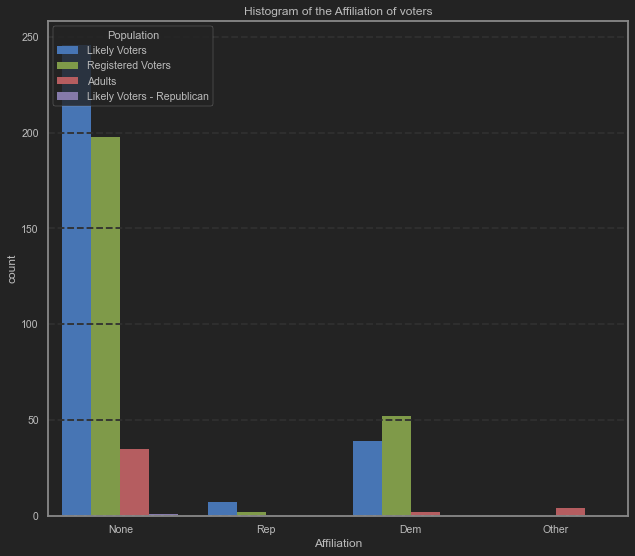

In [8]:
sns.countplot('Affiliation', data = poll_df, hue = 'Population')

plt.title("Histogram of the Affiliation of voters")

In [9]:
poll_df['Population'].value_counts()

Likely Voters                 292
Registered Voters             252
Adults                         41
Likely Voters - Republican      1
Name: Population, dtype: int64

In [10]:
poll_df['Affiliation'][poll_df['Population'] == 'Likely Voters - Republican']

452    None
Name: Affiliation, dtype: object

Interestingly, the only population to be considered a likely republican voter had no affiliations.

Looks like we have a strong showing of likely voters and Registered Voters, so the poll data should hopefully be a good reflection on the populations polled.

Interested in the averages for Obama, Romney, and the polled people who remained undecided.

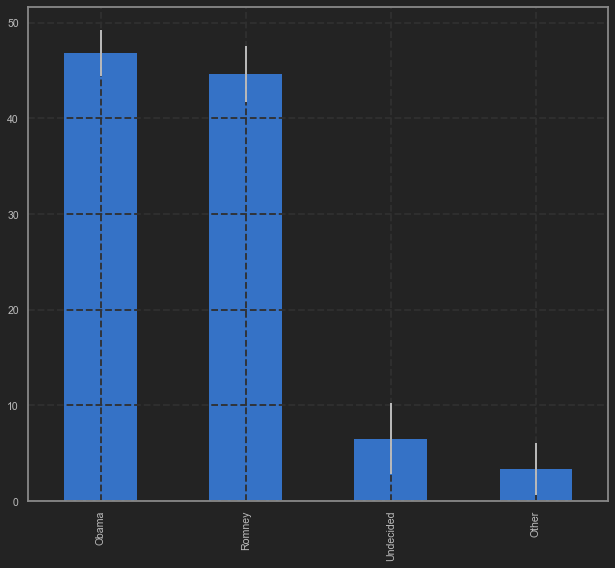

In [11]:
# First we'll get the average
avg = pd.DataFrame(poll_df.mean()) 
avg.drop('Number of Observations',axis=0,inplace=True)

# After that let's get the error
std = pd.DataFrame(poll_df.std())
std.drop('Number of Observations',axis=0,inplace=True)

# now plot using pandas built-in plot, with kind='bar' and yerr='std'
avg.plot(yerr=std,kind='bar',legend=False)

Interesting to see how close these polls seem to be, especially considering the Undecided and Other factor. Let's take a look at the numbers

In [12]:
# Concatenate our Average and Std DataFrames
poll_avg = pd.concat([avg,std],axis=1)

# Rename columns
poll_avg.columns = ['Average','STD']

poll_avg

,Average,STD
Obama,46.805461,2.422058
Romney,44.614334,2.906180
Undecided,6.550827,3.701754
Other,3.376238,2.692726


Looks like the polls indicate it as a fairly close race, but what about the undecided voters? Most of them will likely vote for one of the candidates once the election occurs. If we assume we split the undecided evenly between the two candidates the observed difference should be an unbiased estimate of the final difference.

We can do a quick time series analysis of the voter sentiment by plotting Obama/Romney favour versus the Poll End Dates.

Note: the time is in reverse chronological order. Also keep in mind the multiple polls per end date.

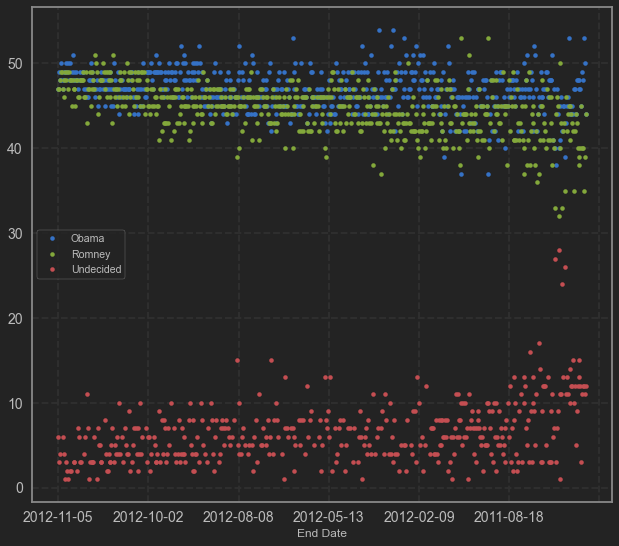

In [13]:
poll_df.plot(x='End Date',y=['Obama','Romney','Undecided'],marker='.',linestyle='', fontsize = 14)

This is a very rough visualisation of the polls and not much insight can be taken from this. In order to gain a better visualisation, its best that we create a new DataFrame to take into account the difference between Romney and Obama in the polls and how it changes as we look back over the months.

For this we need to use datetime to create timestamps.

In [14]:
import datetime

In [15]:
poll_df['Difference'] = (poll_df.Obama - poll_df.Romney)/100 # Speaking in terms of percentage points

poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Partisan,Affiliation,Difference
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,Nonpartisan,None,0.00
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,Nonpartisan,None,0.02
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,Nonpartisan,None,0.00
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,Nonpartisan,None,0.01
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,Nonpartisan,None,-0.01


A positive difference shows a favour for Obama, negative difference shows a favour for Romney.

Now to see if we can visualise this sentiment in difference changed over time.

In [16]:
poll_df = poll_df.groupby(['Start Date'], as_index = False).mean() 
# False to keep 0,1,2,.... Index. Take the mean of the polls on that day

poll_df.info() # Only 357 rows now

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 356
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Start Date              357 non-null    object 
 1   Number of Observations  346 non-null    float64
 2   Obama                   357 non-null    float64
 3   Romney                  357 non-null    float64
 4   Undecided               296 non-null    float64
 5   Other                   162 non-null    float64
 6   Difference              357 non-null    float64
dtypes: float64(6), object(1)
memory usage: 22.3+ KB


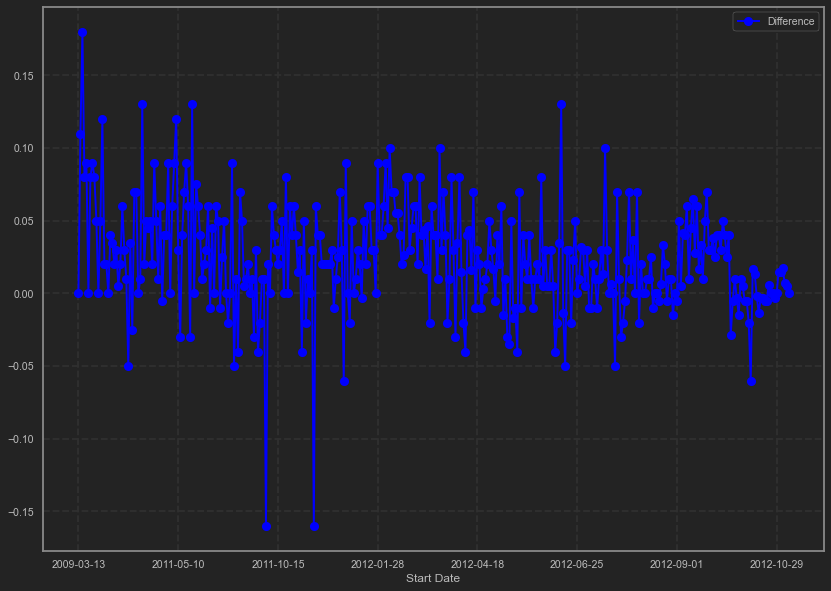

In [17]:
fig = poll_df.plot('Start Date', 'Difference', 
                    marker = 'o',
                    linestyle = '-',
                    color = 'blue',
                    figsize = (14,10))

Need to plot marker lines on the dates of the debates and see if there is any general insight to the poll results.

Debate dates were Oct 3, Oct 11 and Oct 22. 

Going to plot lines as markers then zoom in on October.

To find the xlimits for the figure, we need to find out where the index for the month of October 2012 is.

In [18]:
row_in = 0
xlimit = []

# Cycle through dates until 2012-10 is found, then print row index
for date in poll_df['Start Date']:
    if date[0:7] == '2012-10':
        xlimit.append(row_in)
        row_in += 1
    else:
        row_in += 1
        
print (min(xlimit))
print (max(xlimit))

325
352


These are our x-limits, so now we can create our figure.

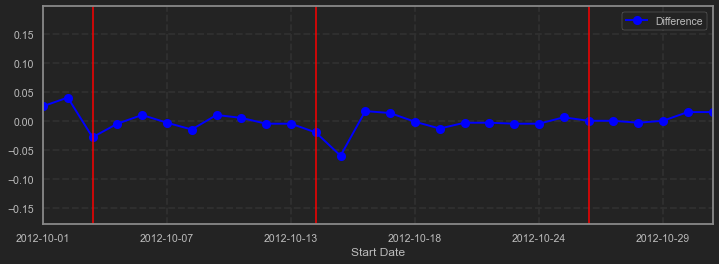

In [19]:
fig = poll_df.plot('Start Date','Difference',
                   figsize=(12,4),
                   marker='o',
                   linestyle='-',
                   color='blue',
                   xlim=(min(xlimit),max(xlimit)))

# Add markers
plt.axvline(x=min(xlimit)+2, linewidth = 1.5, color = 'red') #October 3rd
plt.axvline(x=min(xlimit)+11, linewidth = 1.5, color='red') #October 11th
plt.axvline(x=min(xlimit)+22, linewidth = 1.5, color='red') #October 22nd

Here it seems that the polls reflect a dip for Obama after the first and second debate , meaning that more people voted for Romney. However, more people voted for Obama after the third debate.

Interesting to see why there was a massive spike for Obama votes just after the 2nd debate.

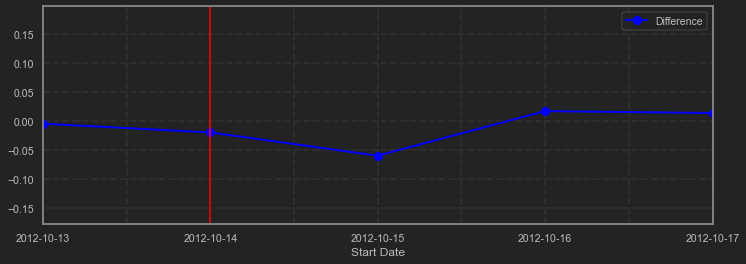

In [20]:
fig = poll_df.plot('Start Date','Difference',
                   figsize=(12,4),
                   marker='o',
                   linestyle='-',
                   color='blue',
                   xlim=(min(xlimit)+10,min(xlimit)+14))

plt.axvline(x=min(xlimit)+11, linewidth = 1.5, color='red') #October 11th

It would be beneficial if we had the geographical location of each polling station in our DataFrame as it can effect the value of a poll.

In [21]:
poll_df.head()

,Start Date,Number of Observations,Obama,Romney,Undecided,Other,Difference
0,2009-03-13,1403.0,44.0,44.0,12.0,NaN,0.00
1,2009-04-17,686.0,50.0,39.0,11.0,NaN,0.11
2,2009-05-14,1000.0,53.0,35.0,12.0,NaN,0.18
3,2009-06-12,638.0,48.0,40.0,12.0,NaN,0.08
4,2009-07-15,577.0,49.0,40.0,11.0,NaN,0.09


In [22]:
poll_df['Obama Votes'] = round(poll_df['Number of Observations'] * ( poll_df['Obama']/100 )) # Cannot have number of votes as decimals
poll_df['Romney Votes'] = round(poll_df['Number of Observations'] * ( poll_df['Romney']/100 ))
poll_df['Undecided Votes'] = round(poll_df['Number of Observations'] * ( poll_df['Undecided']/100 ))

In [23]:
poll_df.head()

,Start Date,Number of Observations,Obama,Romney,Undecided,Other,Difference,Obama Votes,Romney Votes,Undecided Votes
0,2009-03-13,1403.0,44.0,44.0,12.0,NaN,0.00,617.0,617.0,168.0
1,2009-04-17,686.0,50.0,39.0,11.0,NaN,0.11,343.0,268.0,75.0
2,2009-05-14,1000.0,53.0,35.0,12.0,NaN,0.18,530.0,350.0,120.0
3,2009-06-12,638.0,48.0,40.0,12.0,NaN,0.08,306.0,255.0,77.0
4,2009-07-15,577.0,49.0,40.0,11.0,NaN,0.09,283.0,231.0,63.0


In [24]:
poll_df['Obama Cumulative Votes'] = np.cumsum(poll_df['Obama Votes'])
poll_df['Romney Cumulative Votes'] = np.cumsum(poll_df['Romney Votes'])

In [25]:
poll_df.head()

,Start Date,Number of Observations,Obama,Romney,Undecided,Other,Difference,Obama Votes,Romney Votes,Undecided Votes,Obama Cumulative Votes,Romney Cumulative Votes
0,2009-03-13,1403.0,44.0,44.0,12.0,NaN,0.00,617.0,617.0,168.0,617.0,617.0
1,2009-04-17,686.0,50.0,39.0,11.0,NaN,0.11,343.0,268.0,75.0,960.0,885.0
2,2009-05-14,1000.0,53.0,35.0,12.0,NaN,0.18,530.0,350.0,120.0,1490.0,1235.0
3,2009-06-12,638.0,48.0,40.0,12.0,NaN,0.08,306.0,255.0,77.0,1796.0,1490.0
4,2009-07-15,577.0,49.0,40.0,11.0,NaN,0.09,283.0,231.0,63.0,2079.0,1721.0


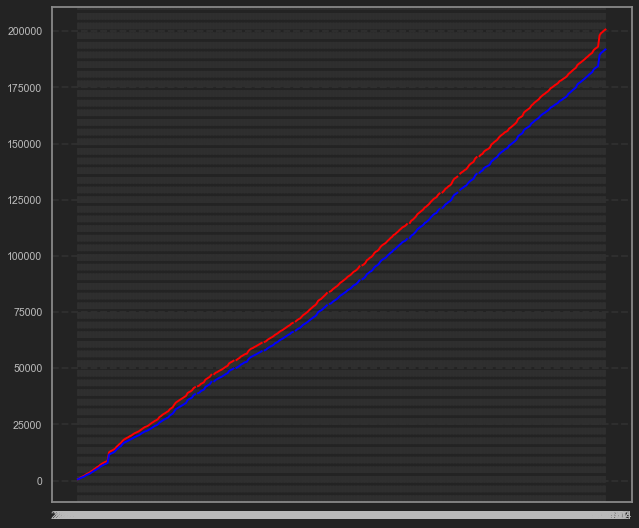

In [27]:
plt.plot('Start Date','Obama Cumulative Votes', data = poll_df, color = 'red')
plt.plot('Start Date','Romney Cumulative Votes', data = poll_df, color = 'blue')

We see that from the start, Obama wins by the number of votes.